# Explore CTs
Here I'm looking through our cell type annotations across the UMAP and in certain conditions to find some interesting effects due to the stimulation conditions.

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce
import diffxpy.api as de
import anndata

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
print(sc.__version__)
sc.settings.n_jobs=30

1.5.1


In [3]:
prefix = '/data/codec/production.run/'

### Load in Data

In [4]:
path = prefix + 'mrna/h5ads/concat.3.h5ad'

concat = sc.read_h5ad(path)

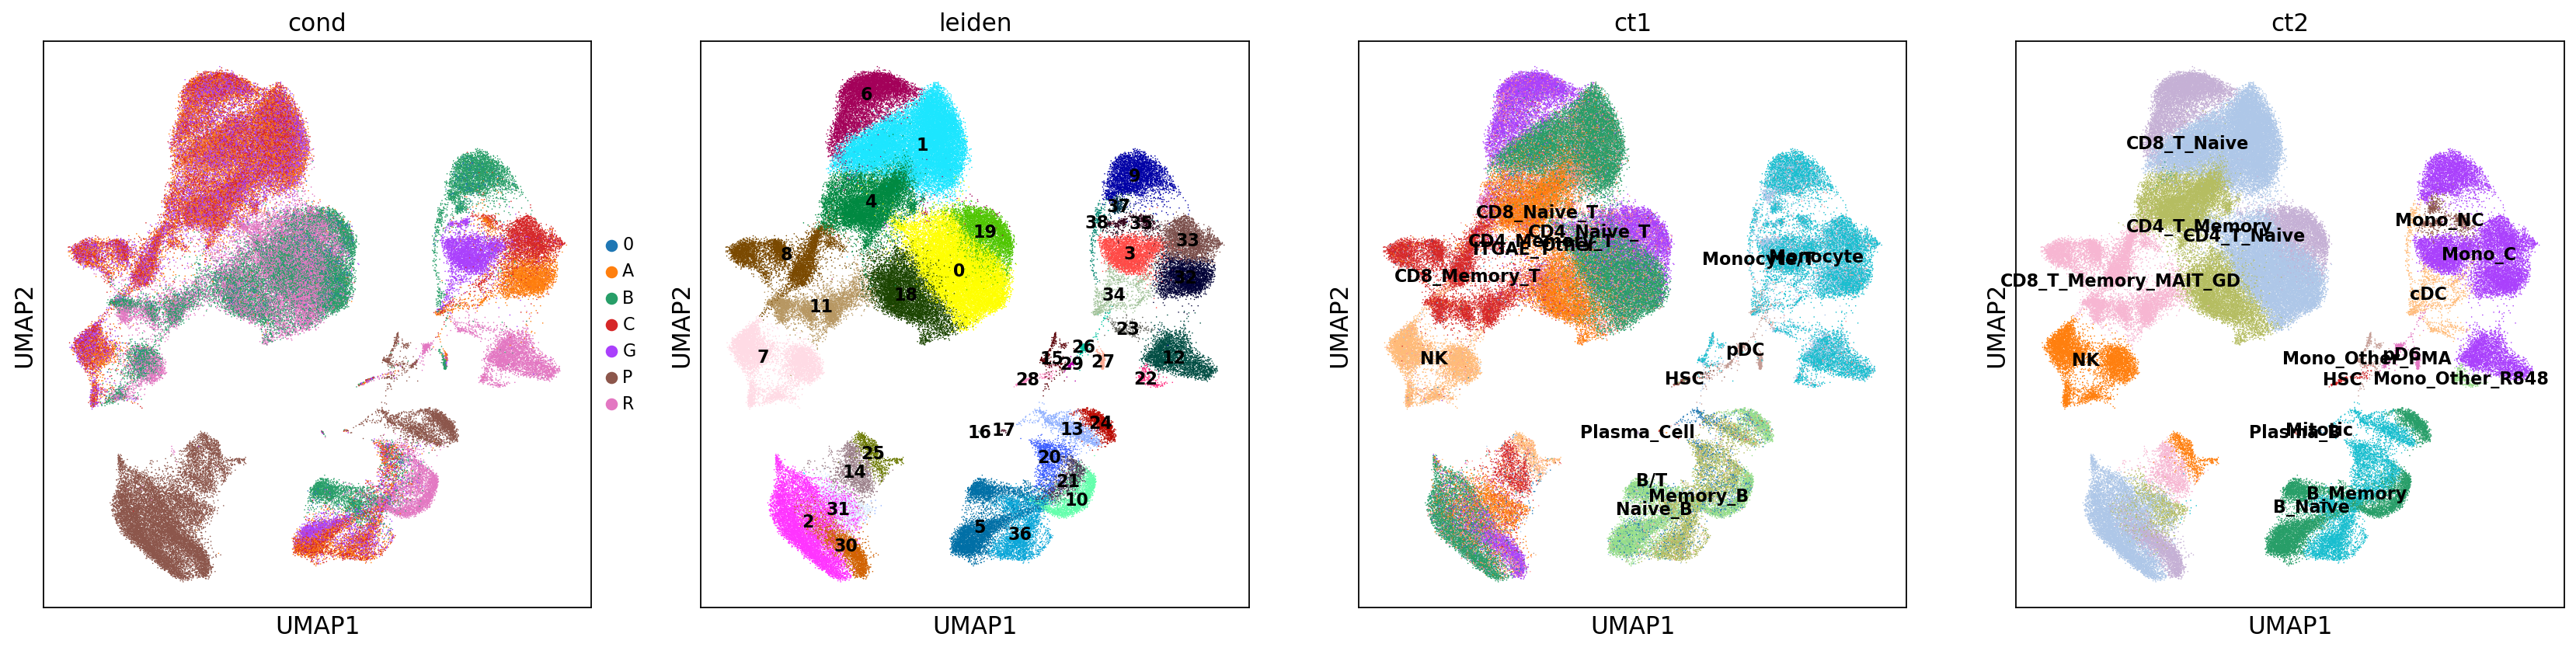

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(26,6))
for color, ax, loc in tqdm(zip(['cond', 'leiden', 'ct1', 'ct2'], ax, ['right margin', 'on data', 'on data', 'on data'])):
    sc.pl.umap(concat,color=color, ax=ax, show=False, return_fig=False, size=2, legend_loc=loc, legend_fontsize=10)

In [7]:
def get_raw_adts(obs_names):
    path = prefix + 'adts/pkls/concat.adts.pkl'
    
    with open(path,'rb') as file:
        return pkl.load(file)[obs_names, :]

def get_raw_mrna(obs_names):
    path = prefix + 'mrna/pkls/aggr/wells.sng.w_covars.pkl'
    
    with open(path,'rb') as file:
        wells = pkl.load(file)
    
    for well in wells:
        wells[well]['adata'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata'].obs_names]
    
    return wells[0]['adata'].concatenate(*[wells[i]['adata'] for  i in range(1, 12)])[obs_names,:]
    
def clr_normalize_column(x):
    normed_column = np.log1p((x) / (np.exp(sum(np.log1p((x)[x > 0 ])) / len(x + 1))))
    return normed_column

def clr_normalize(x):
    normed_matrix = np.apply_along_axis(clr_normalize_column, 1, x)
    return normed_matrix
    
def get_raw(adata, transformed=True):
    raw_mrna = get_raw_mrna(adata.obs_names)
    raw_adts = get_raw_adts(adata.obs_names)
    
    adata.obs['adts_n_counts'] = raw_adts.X.toarray().sum(axis=1)
    
    if transformed == True:
        sc.pp.normalize_per_cell(raw_mrna,counts_per_cell_after=1e6)
        sc.pp.log1p(raw_mrna)
        
        sc.pp.normalize_per_cell(raw_adts, counts_per_cell_after=1e6);
        raw_adts.X = clr_normalize(raw_adts.X.toarray())
    
    return raw_mrna, raw_adts

In [8]:
raw_mrna, raw_adts = get_raw(concat, transformed=False)

In [13]:
free_ids = np.unique(concat.obs['free_id'].values)

In [14]:
cond_id = list(it.product(['A', 'B', 'C', 'G', 'P', 'R'], free_ids))

In [17]:
cond_id_df = pd.DataFrame(cond_id, columns=['COND', 'FID'])

In [18]:
cond_id_df

COND FID
0      A   0
1      A   1
2      A  10
3      A  11
4      A  12
..   ...  ..
379    R  62
380    R  63
381    R   7
382    R   8
383    R   9

[384 rows x 2 columns]

In [21]:
counts_genes = list()
cell_counts = list()
for cond, free_id in tqdm(cond_id):
    arr = raw_mrna[(raw_mrna.obs['cond'] == cond) & (raw_mrna.obs['free_id'] == free_id)].X.toarray()
    cell_counts.append(len(arr))
    counts_genes.append(arr.sum(axis=0))

In [22]:
cond_id_df = cond_id_df.join(pd.DataFrame(data=np.array(cell_counts),columns=['NUM_CELLS']))
cond_id_df = cond_id_df.join(pd.DataFrame(data=np.array(counts_genes),columns=raw_mrna.var_names))

In [23]:
cond_id_df

COND FID  NUM_CELLS  AL627309.1  AL627309.3  AL669831.5  LINC00115  \
0      A   0        502         2.0         0.0        14.0       11.0   
1      A   1        562         3.0         1.0        18.0       16.0   
2      A  10        843         1.0         1.0        40.0       16.0   
3      A  11        270         0.0         0.0         5.0        4.0   
4      A  12        353         0.0         0.0         8.0        8.0   
..   ...  ..        ...         ...         ...         ...        ...   
379    R  62        161         1.0         0.0         1.0        5.0   
380    R  63        201         0.0         0.0         5.0        6.0   
381    R   7        506         1.0         0.0         8.0        7.0   
382    R   8        464         0.0         0.0        14.0       12.0   
383    R   9        540         0.0         0.0        13.0       16.0   

     FAM41C  AL645608.3  SAMD11  ...  BX004987.1  AC145212.1  MAFIP  \
0       9.0         0.0     0.0  ...         0.0         2.0    4.0   
1       9.0         0.0     0.0  ...         2.0         0.0    7.0   
2       6.0         2.0     0.0  ...         1.0         2.0    3.0   
3       4.0         1.0     0.0  ...         0.0         0.0    0.0   
4       7.0         0.0     0.0  ...         0.0         0.0    1.0   
..      ...         ...     ...  ...         ...         ...    ...   
379     3.0         0.0     0.0  ...         0.0         0.0    0.0   
380     5.0         0.0     0.0  ...         1.0         0.0    0.0   
381     4.0         0.0     0.0  ...         2.0         1.0    5.0   
382     7.0         0.0     1.0  ...         0.0         0.0    5.0   
383     7.0         0.0     0.0  ...         1.0         0.0    3.0   

     AC011043.1  AL592183.1  AC007325.4  AL354822.1  AC004556.1  AC233755.1  \
0           1.0        19.0         3.0        20.0         0.0         0.0   
1           1.0         2.0         1.0        15.0         2.0         0.0   
2           5.0        10.0         5.0        19.0         2.0         0.0   
3           0.0        11.0         4.0         4.0         6.0         0.0   
4           0.0        17.0         0.0         4.0       105.0         0.0   
..          ...         ...         ...         ...         ...         ...   
379         0.0         0.0         1.0         1.0         2.0         1.0   
380         0.0         5.0         2.0         4.0        29.0         0.0   
381         0.0         6.0         2.0        22.0        96.0         1.0   
382         1.0         6.0         2.0         4.0         0.0         1.0   
383         0.0         4.0         4.0         7.0         7.0         0.0   

     AC240274.1  
0          19.0  
1           7.0  
2           4.0  
3           8.0  
4          10.0  
..          ...  
379         6.0  
380        10.0  
381        11.0  
382         8.0  
383         8.0  

[384 rows x 20306 columns]

In [25]:
cond_id_df.isna().sum().sum()

0

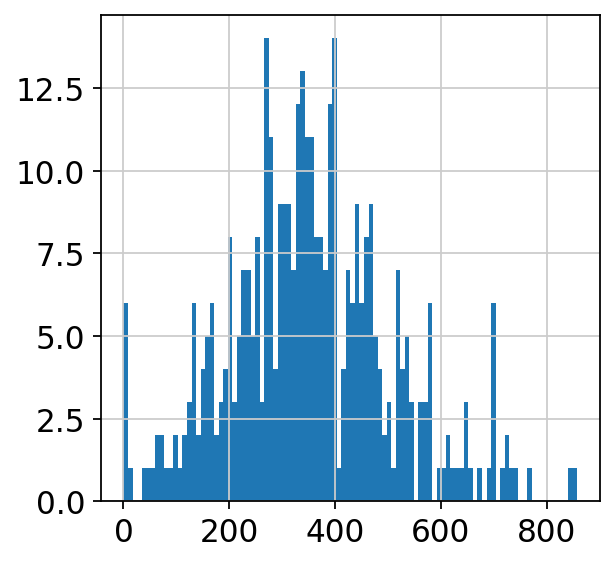

In [26]:
plt.hist(cond_id_df['NUM_CELLS'].values,bins=100);

In [27]:
cond_id_df.drop(columns=['NUM_CELLS'],inplace=True)

In [28]:
# AVOID RE-RUNNING THIS AGAIN
cond_id_df.to_pickle(prefix + 'mrna/pkls/aggr/pseudobulk.conds.inds.pkl')

# Figures

In [150]:
fig_prefix = '/data/codec/production.run/figs/'

In [152]:
concat_ctrl.uns['ct2_colors'] = ct2_colors

In [175]:
filename = fig_prefix + 'hiq.umaps/umap.control.cts.png'
fig, ax = plt.subplots(1, 1, figsize=(10,8))
sc.pl.umap(concat_ctrl, color='ct2', ax=ax, return_fig=False, 
           show=False, title="Control Cells by Cell Type/State", size=8)
plt.tight_layout()
plt.savefig(filename, dpi=80)
plt.close()

In [177]:
concat_ctrl.obs['Cell Type/State'] = concat_ctrl.obs['ct2']
concat_ctrl.uns['Cell Type/State_colors'] = ct2_colors

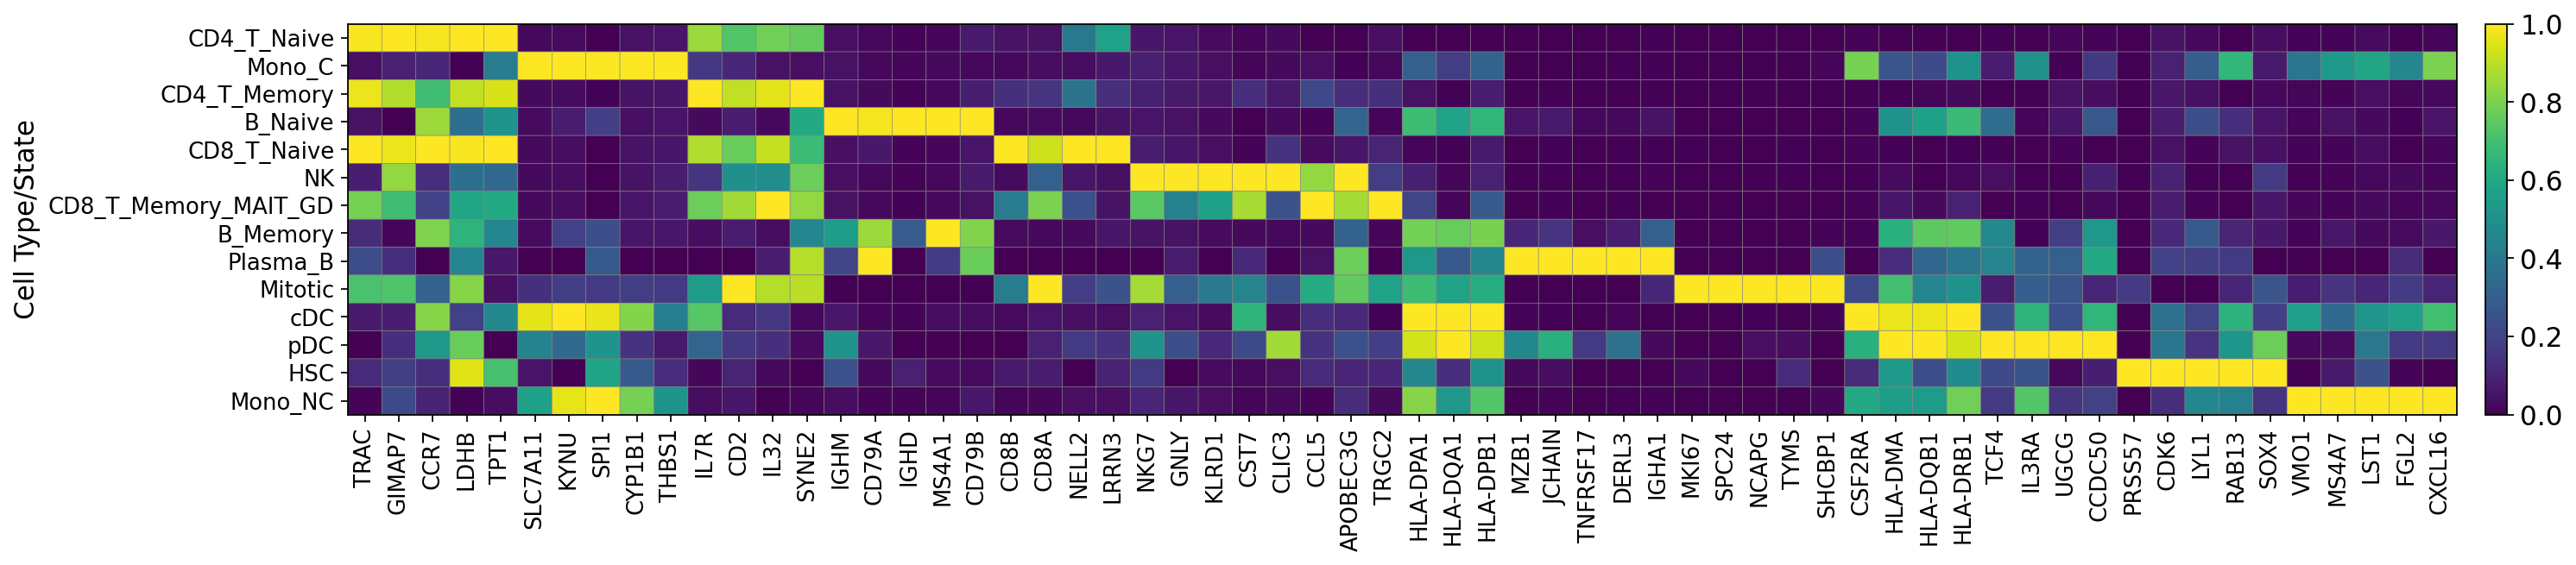

In [194]:
figdir = fig_prefix + 'misc/'
sc.settings.figdir = figdir
sc.pl.matrixplot(concat_ctrl, var_names=transcripts_to_plot, 
                 groupby='Cell Type/State', dendrogram=False, standard_scale='var', save='.ctrl.cts.diffex.genes.png');

In [197]:
concat_ctrl_high_count.obs['Cell Type/State'] = concat_ctrl_high_count.obs['ct2']
concat_ctrl_high_count.uns['Cell Type/State_colors'] = ct2_colors

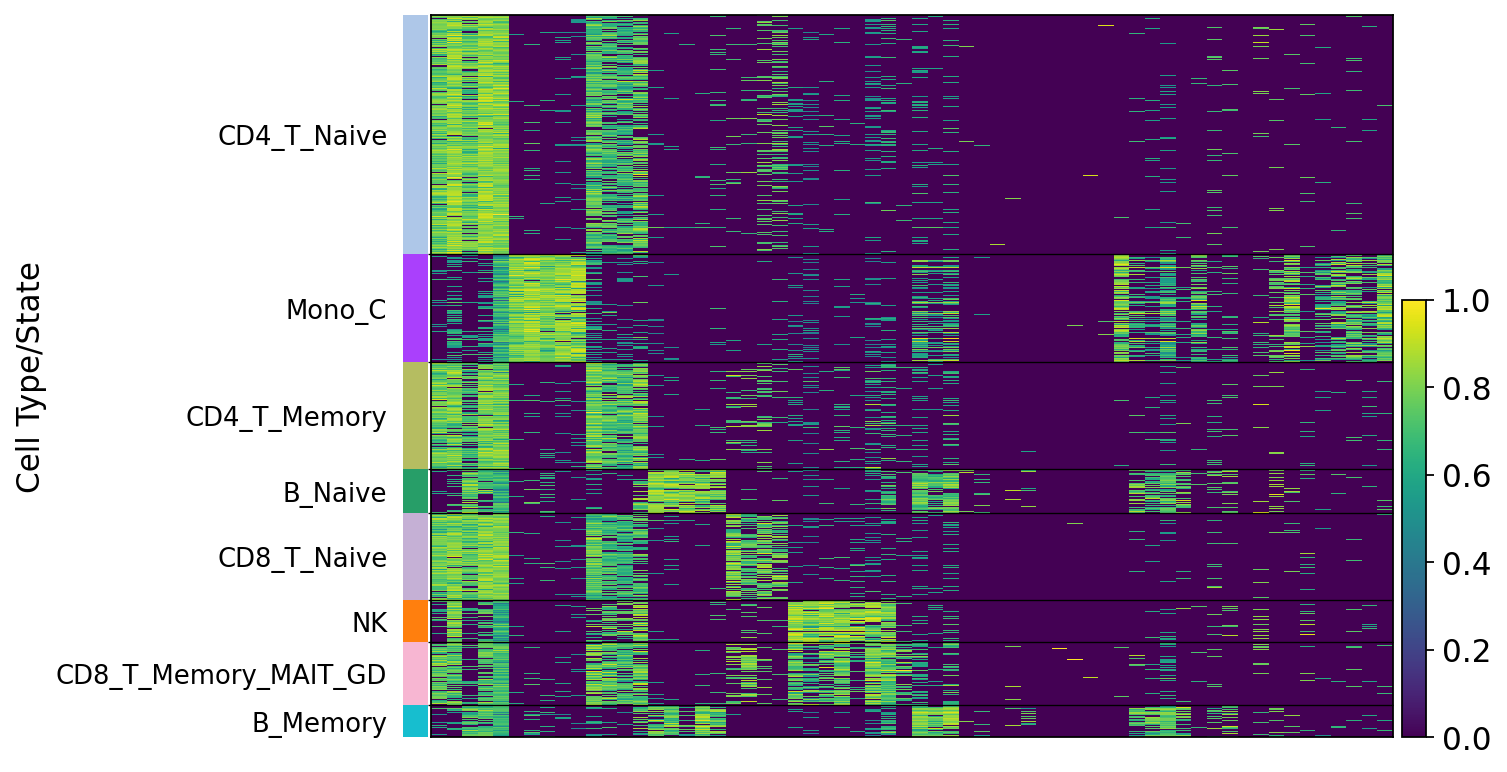

In [200]:
figdir = fig_prefix + 'misc/'
sc.settings.figdir = figdir
sc.pl.heatmap(concat_ctrl_high_count, var_names=transcripts_to_plot, 
                 groupby='Cell Type/State', dendrogram=False, standard_scale='var',
              save='.ctrl.highcount.cts.diffex.genes.png');

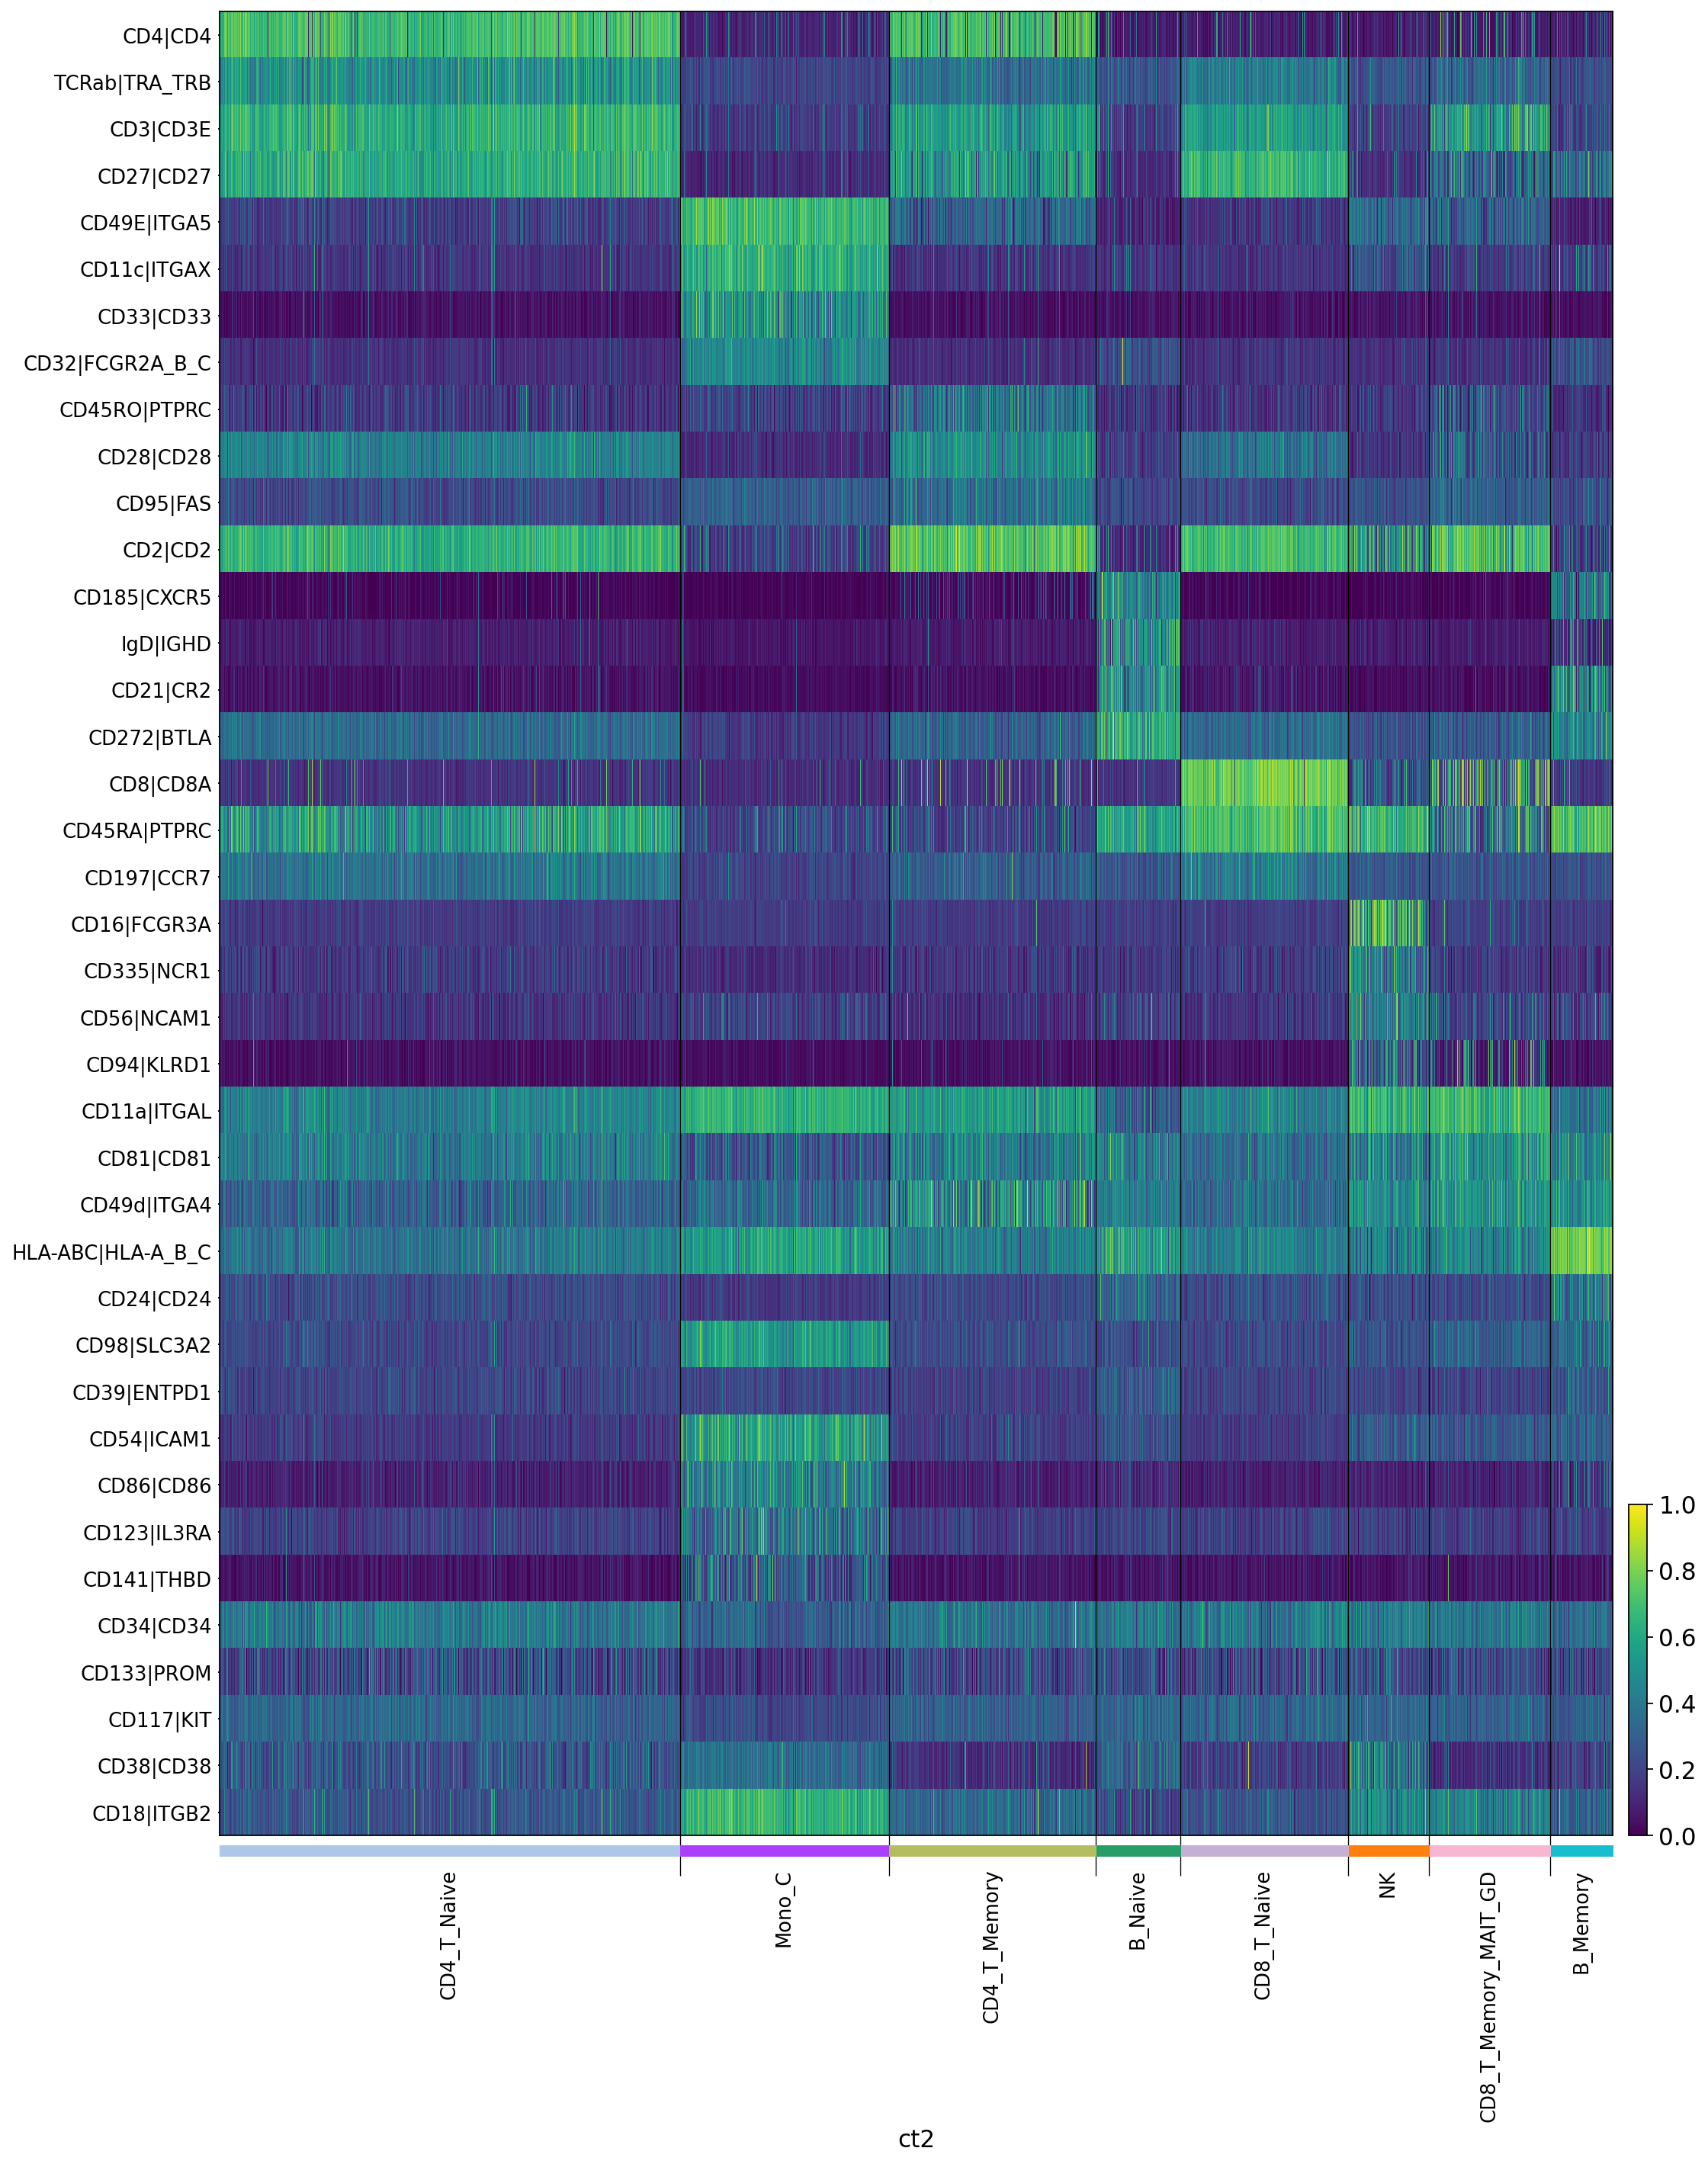

In [203]:
figdir = fig_prefix + 'misc/'
sc.settings.figdir = figdir
sc.pl.heatmap(concat_ctrl_high_count, var_names=features_to_plot, 
              groupby='ct2', standard_scale='var', 
              use_raw=True, swap_axes=True, figsize=(15, 20), save='.ctrl.highcount.cts.diffex.proteins.png');

In [215]:
filename = fig_prefix + 'misc/stacked.bar.cellnumber.condition.ct.png'
labels = clusts
props = dict()

plt.figure(figsize=(10,5))
for cond in conds:
    props[cond] = cond_ct_df.loc[cond].values
lastpos = [0]*len(clusts)
for cond in props:
    plt.bar(labels, props[cond], label=cond, bottom=lastpos)
    lastpos = props[cond] + lastpos

plt.ylabel('Number')
plt.xlabel('Cell Type/State')
plt.title('Number of Cells per Condition per Cell Type/State')
ax = plt.gca()
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
ax.legend();
plt.savefig(filename, dpi=80)
plt.close()

In [216]:
filename = fig_prefix + 'misc/stacked.bar.cellproportion.condition.ct.png'
labels = clusts
props = dict()

plt.figure(figsize=(10,5))
for cond in conds:
    props[cond] = cond_ct_df_div.loc[cond].values
lastpos = [0]*len(clusts)
for cond in props:
    plt.bar(labels, props[cond], label=cond, bottom=lastpos)
    lastpos = props[cond] + lastpos

plt.ylabel('Proportion')
plt.xlabel('Cell Type/State')
plt.title('Proportion of Cells from each Condition per Cell Type/State')
ax = plt.gca()
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
ax.legend();
plt.savefig(filename, dpi=80)
plt.close()

In [228]:
filename = fig_prefix + 'misc/boxplot.ct.proportion.per.ind.png'
fig, ax = plt.subplots(1, 1, figsize=(20,4))
sns.boxplot(data=ind_ct.divide(ind_ct.sum(1),0), ax=ax, palette=color_dict)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');
ax.set_ylabel('Proportion')
ax.set_xlabel('Cell Type/State');
ax.set_title('Proportion of Each Cell Type Per Individual', fontsize=17);
plt.savefig(filename, dpi=80)
plt.close()

# EXTRA:

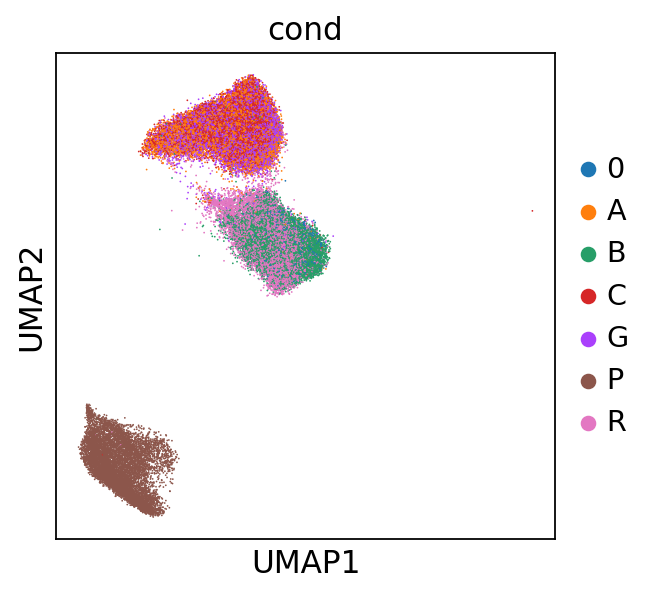

In [7]:
sc.pl.umap(concat_cd4_naive,color='cond');

In [22]:
cond_to_test = 'A'

In [23]:
concat_cd4_naive.obs['cond_to_test'] = (concat_cd4_naive.obs['cond'] == cond_to_test).values.astype(int)

In [59]:
test_tt = de.test.t_test(data=concat_cd4_naive, grouping="cond_to_test")
fc = test_tt.log10_fold_change()
mq = -test_tt.log10_qval_clean()

In [60]:
plt.hist(fc,bins=100);

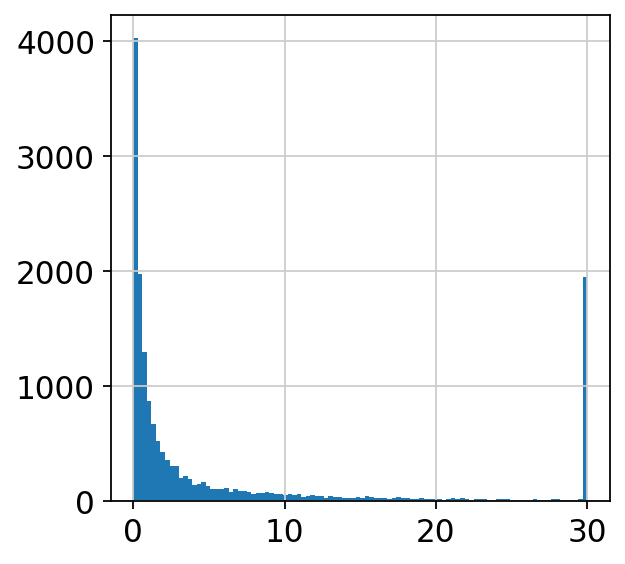

In [61]:
plt.hist(mq,bins=100);

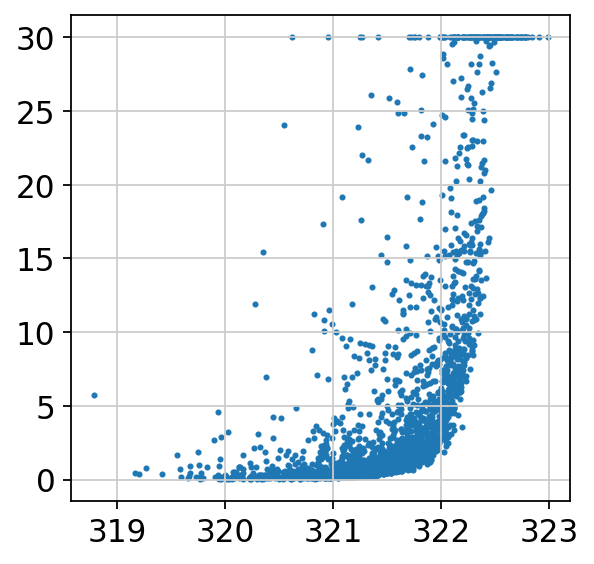

In [56]:
plt.scatter(x=fc[fc > 200], y=mq[fc > 200],s=3);

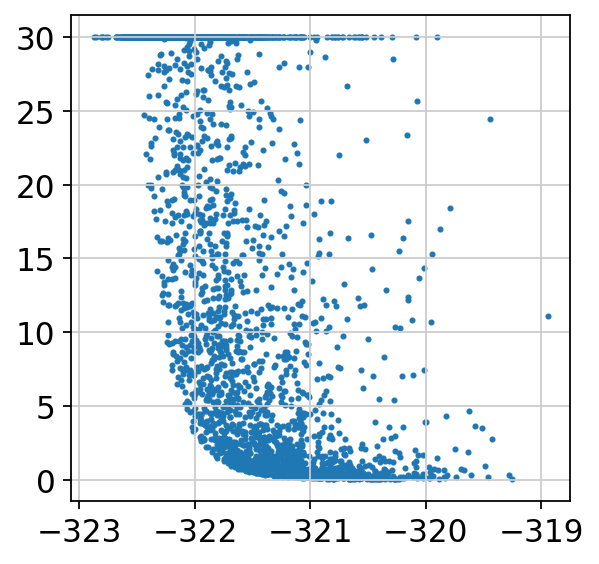

In [62]:
plt.scatter(x=fc[fc < -200], y=mq[fc < -200],s=3);

In [ ]:
fc_thresh = 322
mq_thresh = 25
concat_cd4_naive.var_names[(fc > fc_thresh) & (mq > mq_thresh)].tolist()

In [71]:
fc_thresh = -321
mq_thresh = 25
concat_cd4_naive.var_names[(fc < fc_thresh) & (mq > mq_thresh)].tolist()

['NOC2L',
 'TNFRSF4',
 'B3GALT6',
 'MRPL20',
 'ATAD3B',
 'ATAD3A',
 'ACOT7',
 'DNAJC11',
 'ENO1',
 'SLC25A33',
 'DFFA',
 'SRM',
 'SDHB',
 'EMC1',
 'MRTO4',
 'ECE1',
 'PITHD1',
 'SRSF10',
 'ZNF593',
 'NUDC',
 'IFI6',
 'SESN2',
 'EIF3I',
 'YARS',
 'AK2',
 'SFPQ',
 'MRPS15',
 'GNL2',
 'C1orf109',
 'YRDC',
 'SF3A3',
 'UTP11',
 'AKIRIN1',
 'PABPC4',
 'MFSD2A',
 'ZMPSTE24',
 'CTPS1',
 'HIVEP3',
 'YBX1',
 'EBNA1BP2',
 'DPH2',
 'SLC6A9',
 'EIF2B3',
 'HPDL',
 'NASP',
 'BTF3L4',
 'MAGOH',
 'MRPL37',
 'CYP2J2',
 'MIER1',
 'IL12RB2',
 'SERBP1',
 'GADD45A',
 'TYW3',
 'RABGGTB',
 'NEXN',
 'FUBP1',
 'IFI44L',
 'IFI44',
 'RPF1',
 'C1orf52',
 'ZNHIT6',
 'SELENOF',
 'GBP1',
 'GBP2',
 'GBP4',
 'GBP5',
 'LRRC8B',
 'LRRC8C',
 'SARS',
 'PSMA5',
 'CSF1',
 'WDR77',
 'SLC16A1',
 'BCAS2',
 'SIKE1',
 'ATP1A1',
 'TTF2',
 'WDR3',
 'WARS2',
 'PHGDH',
 'RBM8A',
 'OTUD7B',
 'CIART',
 'CHTOP',
 'ILF2',
 'KCNN3',
 'SCAMP3',
 'MSTO1',
 'PMF1',
 'CCT3',
 'GPATCH4',
 'IFI16',
 'SLAMF1',
 'CD48',
 'PFDN2',
 'ATP1B1',
 'F5'

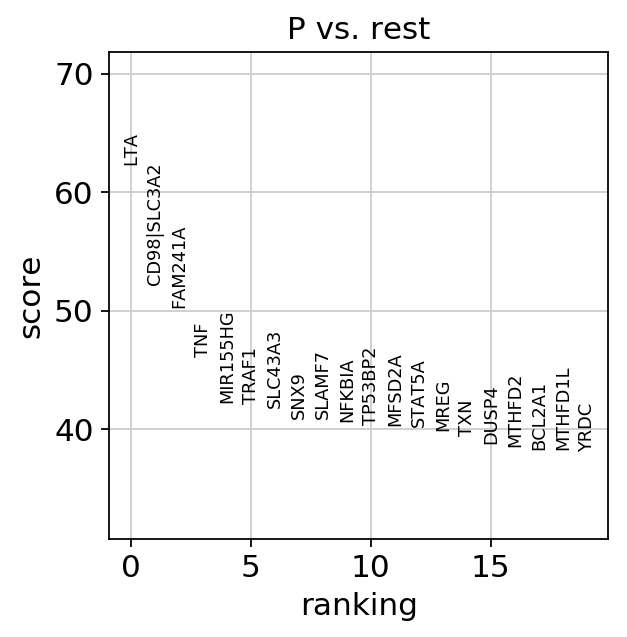

In [101]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(mem_b, groupby='cond', groups=['P'], reference='rest', n_genes=50)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(mem_b, ncols=5, n_genes=20)
sc.settings.verbosity = 4

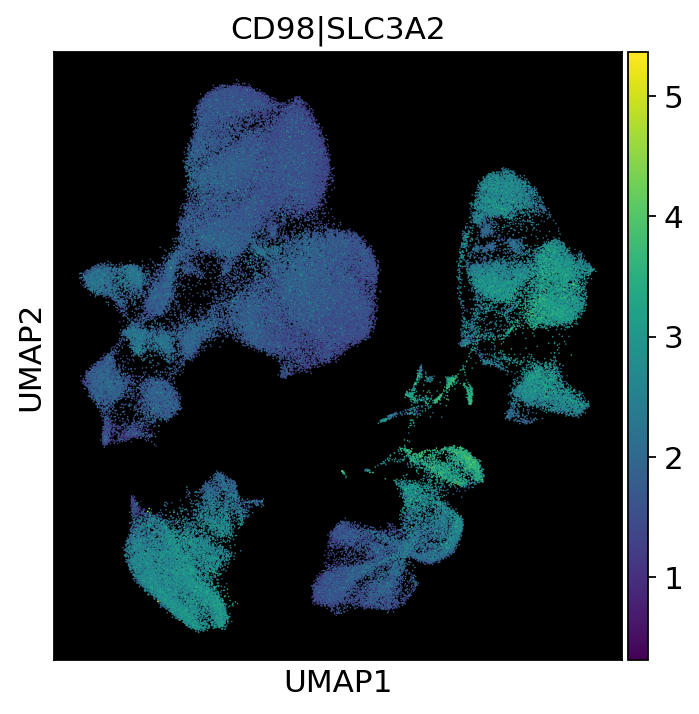

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
for color, ax in zip(['CD98|SLC3A2'], [ax]):
    ax.set_facecolor('black')
    sc.pl.umap(concat, color=color, ax=ax, show=False, return_fig=False, size=2)

In [80]:
cov = 'leiden'

In [81]:
g1 = ['20']
g2 = [i for i in concat[concat.obs['ct2'].isin(['B_Naive','B_Memory'])].obs[cov].dtype.categories if i not in g1]

In [82]:
def grouped_rank(adata, groups, return_genes=True, size=5, n_genes=20, figsize=(5,5), cov='leiden'):

    assert len(groups) == 2
    for i in range(2):
        groups[i] = np.array(groups[i]).astype(str)
        
    grouped_clusts = [i for j in groups for i in j]
    numclusts = np.unique(adata.obs[cov].values)
    groups.append(np.setdiff1d(numclusts, grouped_clusts).astype('<U21'))
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    for clusts, title, ax in zip(groups, ['0','1'], axes):
        adata.obs['val'] = adata.obs[cov].isin(clusts).values
        ax.set_facecolor('black')
        sc.pl.umap(adata,color='val', ax=ax, size=size, show=False, return_fig=False, title=title)
    adata.obs.drop(columns='val', inplace=True)

    adata.obs['rank_compare'] = adata.obs[cov].copy()
    groups_dict = dict(zip(range(3), groups))
    for group in groups_dict:
        for clust in groups_dict[group]:
            adata.obs['rank_compare'].replace(clust, 'ct%s' % group, regex=True, inplace=True)
    adata.obs['rank_compare'] = adata.obs['rank_compare'].str.replace('ct','').astype('category')
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sc.settings.verbosity = 0
    for ax in np.ravel(ax):
        rank_adata = adata.copy()
        sc.tl.rank_genes_groups(rank_adata, groupby='rank_compare', n_genes=n_genes, groups=['0'], reference='1', use_raw=True)
        y = range(n_genes)[::-1]
        x = [i[0] for i in rank_adata.uns['rank_genes_groups']['scores'].tolist()][:n_genes]
        genes = [i[0] for i in rank_adata.uns['rank_genes_groups']['names'].tolist()]
        txts = genes[:n_genes]
        ax.scatter(x, y, s=0)
        for i, txt in enumerate(txts):
            ax.annotate(txt, (x[i], y[i]), rotation=0, size=10)
        ax.set_yticklabels([])
        ax.set_title('0 vs 1')
    sc.settings.verbosity = 4
    adata.obs.drop(columns='rank_compare', inplace=True)
    if return_genes == True:
        return genes
    else:
        return 

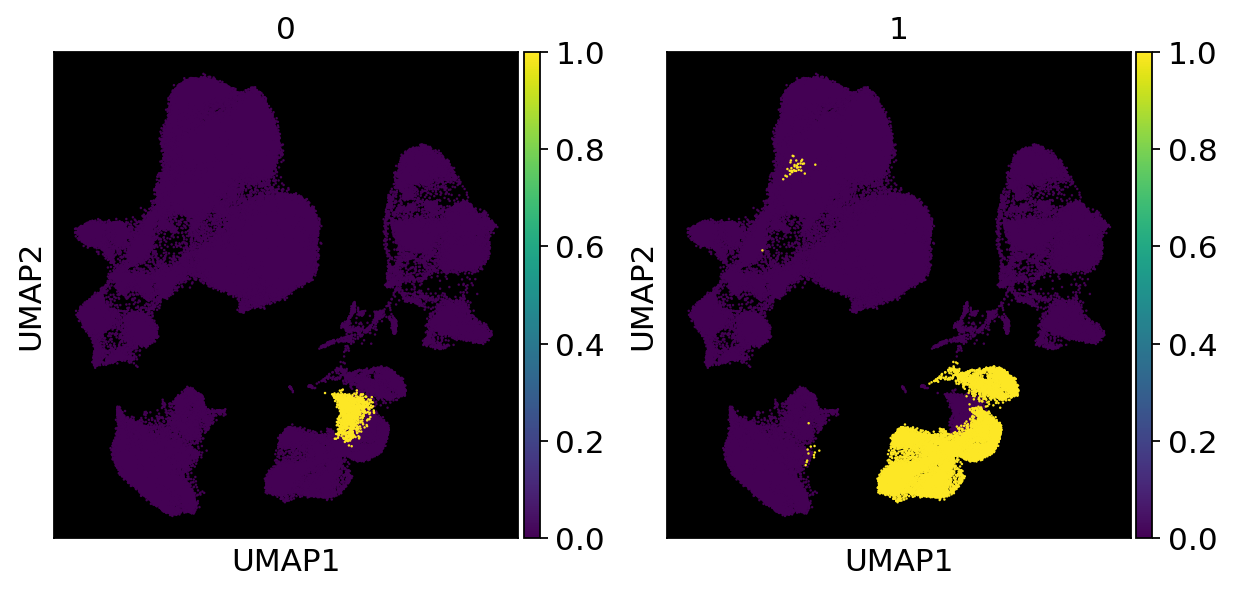

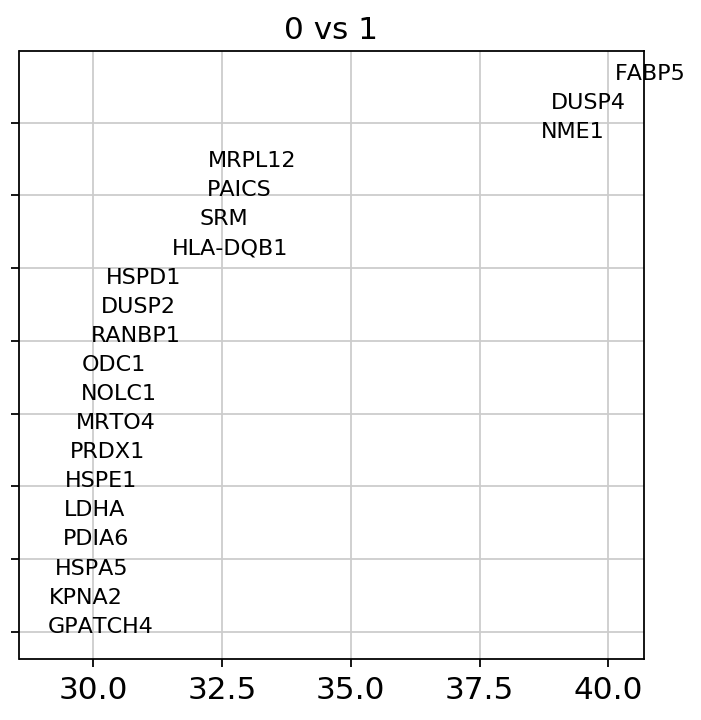

In [83]:
genes = grouped_rank(concat, groups=[g1, g2], size=5, n_genes=20, figsize=(5,5), cov=cov)

In [84]:
df = low_de_make(concat, p=0.2, p_of=g1[0], cov=cov)

In [85]:
de_genes = low_de_compare(df, g1[0], compare=g2)

In [86]:
s = de_genes[:30]

print(s)
# for i in s.index:
#     print(i)

COCH         9.210938
NR4A1        6.226562
LINC01480    6.183594
TEX9         5.429688
ITGB2        5.324219
MYO1E        5.253906
NAB2         5.117188
NR4A2        5.011719
BTN2A2       4.980469
FCRL5        4.761719
TVP23A       4.683594
TNFRSF9      4.667969
SH2D2A       4.156250
SLC15A3      4.132812
TMC8         3.949219
PRAG1        3.779297
AGMAT        3.761719
NEK6         3.757812
CHST11       3.720703
PTPN6        3.656250
GRASP        3.654297
BICDL1       3.634766
HLA-DOA      3.580078
CD72         3.507812
SLC17A9      3.476562
LRMP         3.390625
CARD11       3.341797
GM2A         3.333984
HAGHL        3.324219
TLE1         3.312500
dtype: float16


In [111]:
[i for i in all_features if 'NR4A2' in i]

['NR4A2']

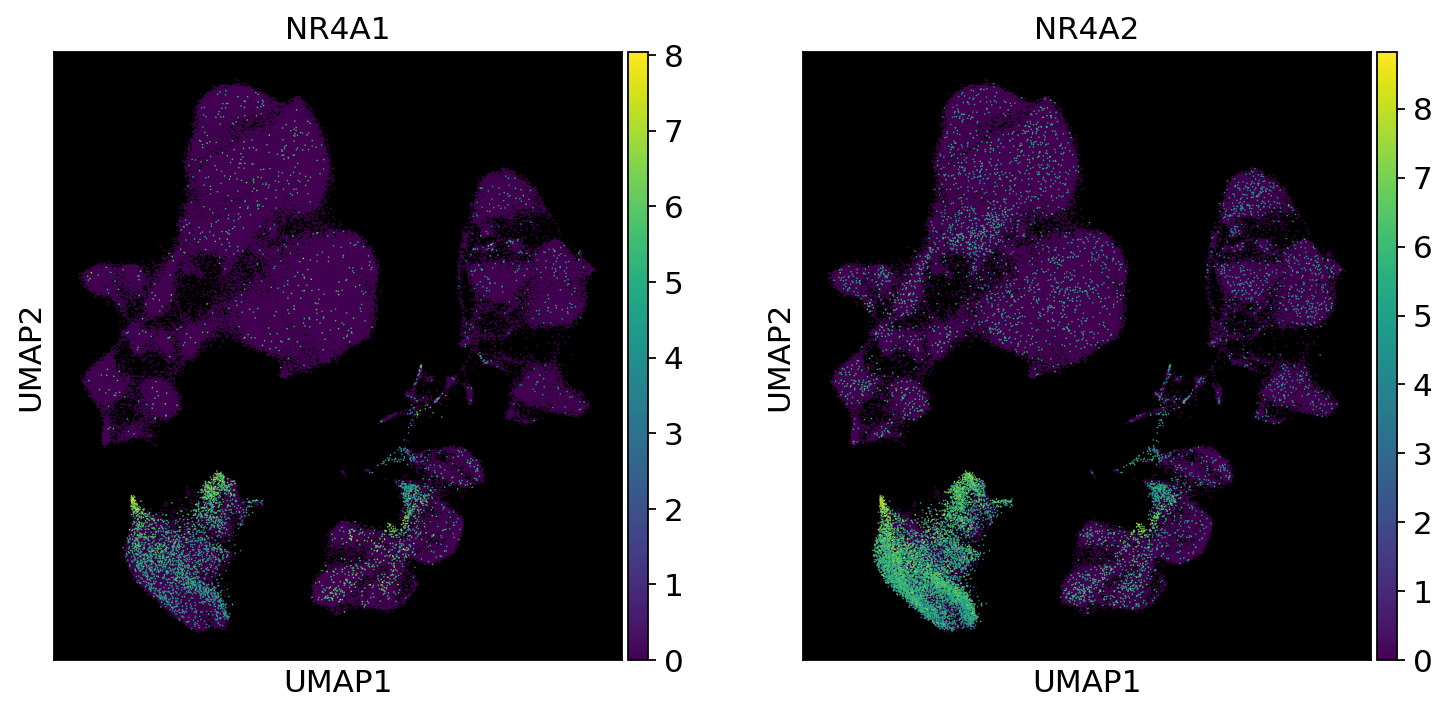

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))
for color, ax in zip(['NR4A1', 'NR4A2'], ax):
    ax.set_facecolor('black')
    sc.pl.umap(concat, color=color, ax=ax, show=False, return_fig=False, size=2)

Trying to set attribute `.uns` of view, copying.


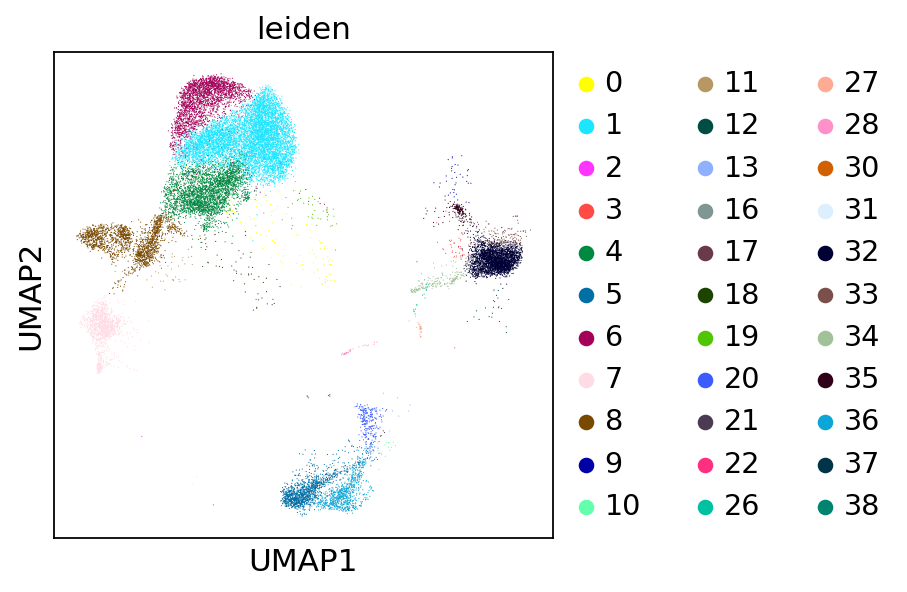

In [110]:
sc.pl.umap(concat[concat.obs['cond'] == 'A'], color='leiden', size=1);

In [131]:
mem_b_p = mem_b[mem_b.obs['cond'] == 'P'].copy()

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


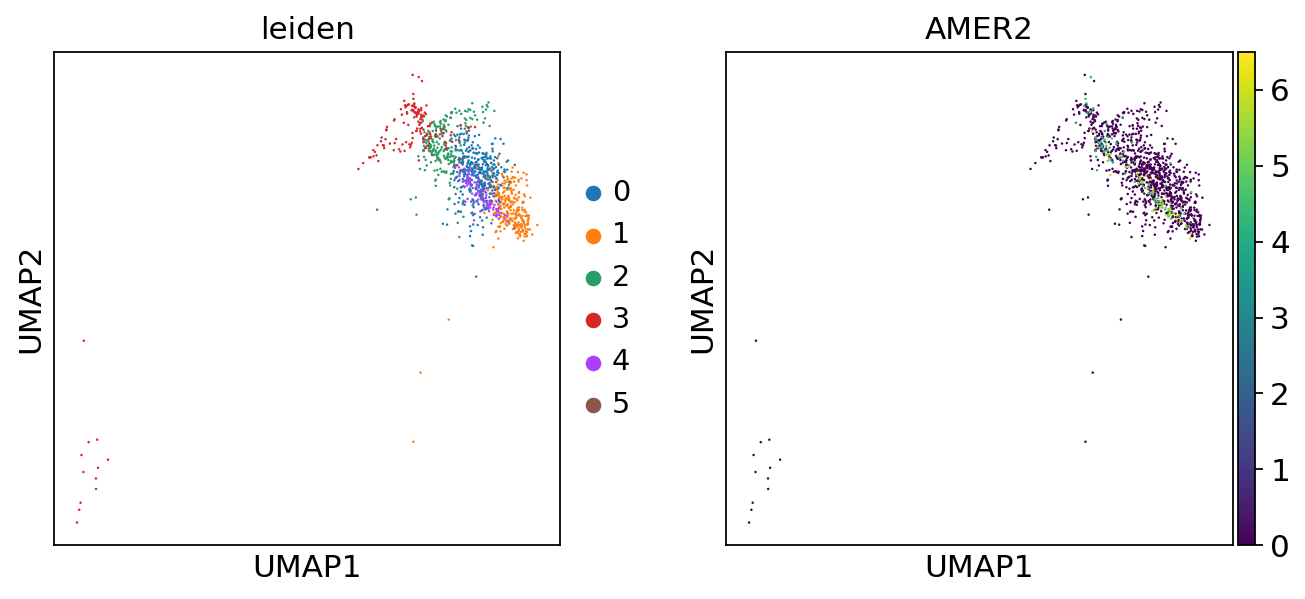

In [172]:
sc.tl.leiden(mem_b_p, resolution=0.5)
sc.pl.umap(mem_b_p, color=['leiden', 'AMER2'], size=5);

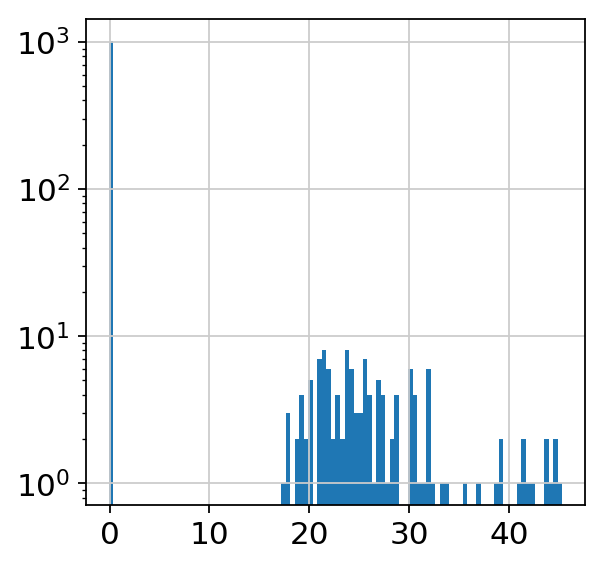

In [134]:
plt.hist(mem_b_p.obs_vector('AMER2'),bins=100);
plt.yscale('log')

In [144]:
mem_b_p.obs['AMER2+'] = mem_b_p.obs_vector('AMER2') > 10
mem_b_p.obs['AMER2+'] = mem_b_p.obs['AMER2+'].astype('category')

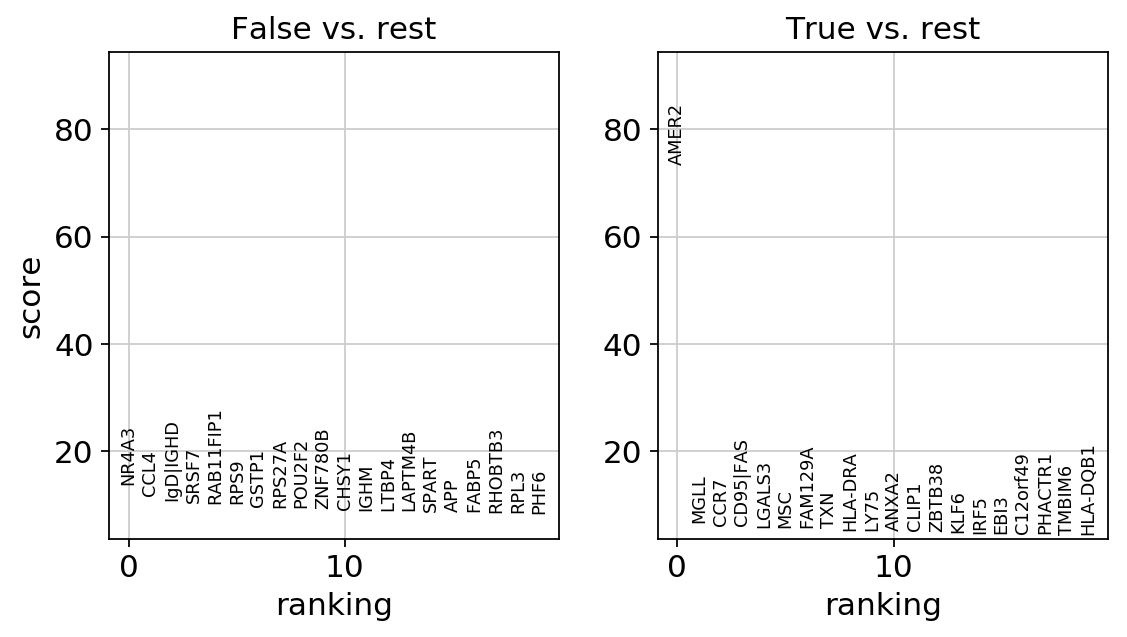

In [145]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(mem_b_p, groupby='AMER2+', n_genes=50)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(mem_b_p, ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [175]:
cov = 'AMER2+'

In [176]:
g1 = [True]
g2 = [i for i in mem_b_p.obs[cov].dtype.categories if i not in g1]

In [187]:
df = low_de_make(mem_b_p, p=0.2, p_of=g1[0], cov=cov)

In [188]:
de_genes = low_de_compare(df, g1[0], compare=g2)

In [192]:
s = de_genes[:20]

# print(s)
for i in s.index:
    print(i)

AMER2
CDCA7
MSC
CPEB2
MIR193BHG
CDKN2C
IRF5
SLC2A6
SPIRE1
USP32
CAPG
OAS3
PAG1
LY75
SLC27A2
SMCO4
SLC41A2
SOCS2
MAP3K20
PDE4D


In [ ]:
fig, ax = plt.subplots(4,4,figsize=(20,20))
for val, ax in tqdm(zip(concat.obs['ct2'].dtype.categories, np.ravel(ax))):
    concat.obs['val'] = concat.obs['ct2'] == val
    ax.set_facecolor('black')
    sc.pl.umap(concat,color='val', ax=ax, show=False, return_fig=False, title=val)
    concat.obs.drop(columns='val', inplace=True)
plt.tight_layout()

In [177]:
[i for i in concat.raw.var_names if 'CD38' in i]

In [194]:
pd.DataFrame(concat_ctrl.uns['rank_genes_groups']['names'].tolist()).loc[:,9].tolist()

['MKI67',
 'SPC24',
 'NCAPG',
 'TYMS',
 'SHCBP1',
 'ESCO2',
 'KIFC1',
 'CDK1',
 'HIST1H1B',
 'BIRC5',
 'ZWINT',
 'CENPW',
 'KIF11',
 'CENPM',
 'CDCA2',
 'TOP2A',
 'CHEK1',
 'NUSAP1',
 'CCNF',
 'BRCA1',
 'NDC80',
 'CENPF',
 'TPX2',
 'ASPM',
 'HMGB3',
 'DHFR',
 'MAD2L1',
 'KIF2C',
 'CCNA2',
 'ATAD2',
 'NCAPD2',
 'H2AFX',
 'CKS1B',
 'PRIM2',
 'BARD1',
 'PHGDH',
 'SGO2',
 'RRM1',
 'EZH2',
 'CKS2',
 'NCAPD3',
 'SAE1',
 'TIAM1',
 'KIF22',
 'FAM111A',
 'TOPBP1',
 'SMC4',
 'CKAP2',
 'SMC2',
 'KPNA2']

In [195]:
features = ['MKI67', 'SPC24', 'NCAPG', 'TYMS', 'SHCBP1', 'ESCO2',
            'KIFC1', 'CDK1', 'HIST1H1B', 'BIRC5', 'ZWINT', 'CENPW',
            'KIF11', 'CENPM', 'CDCA2', 'TOP2A', 'CHEK1', 'NUSAP1'
           ]

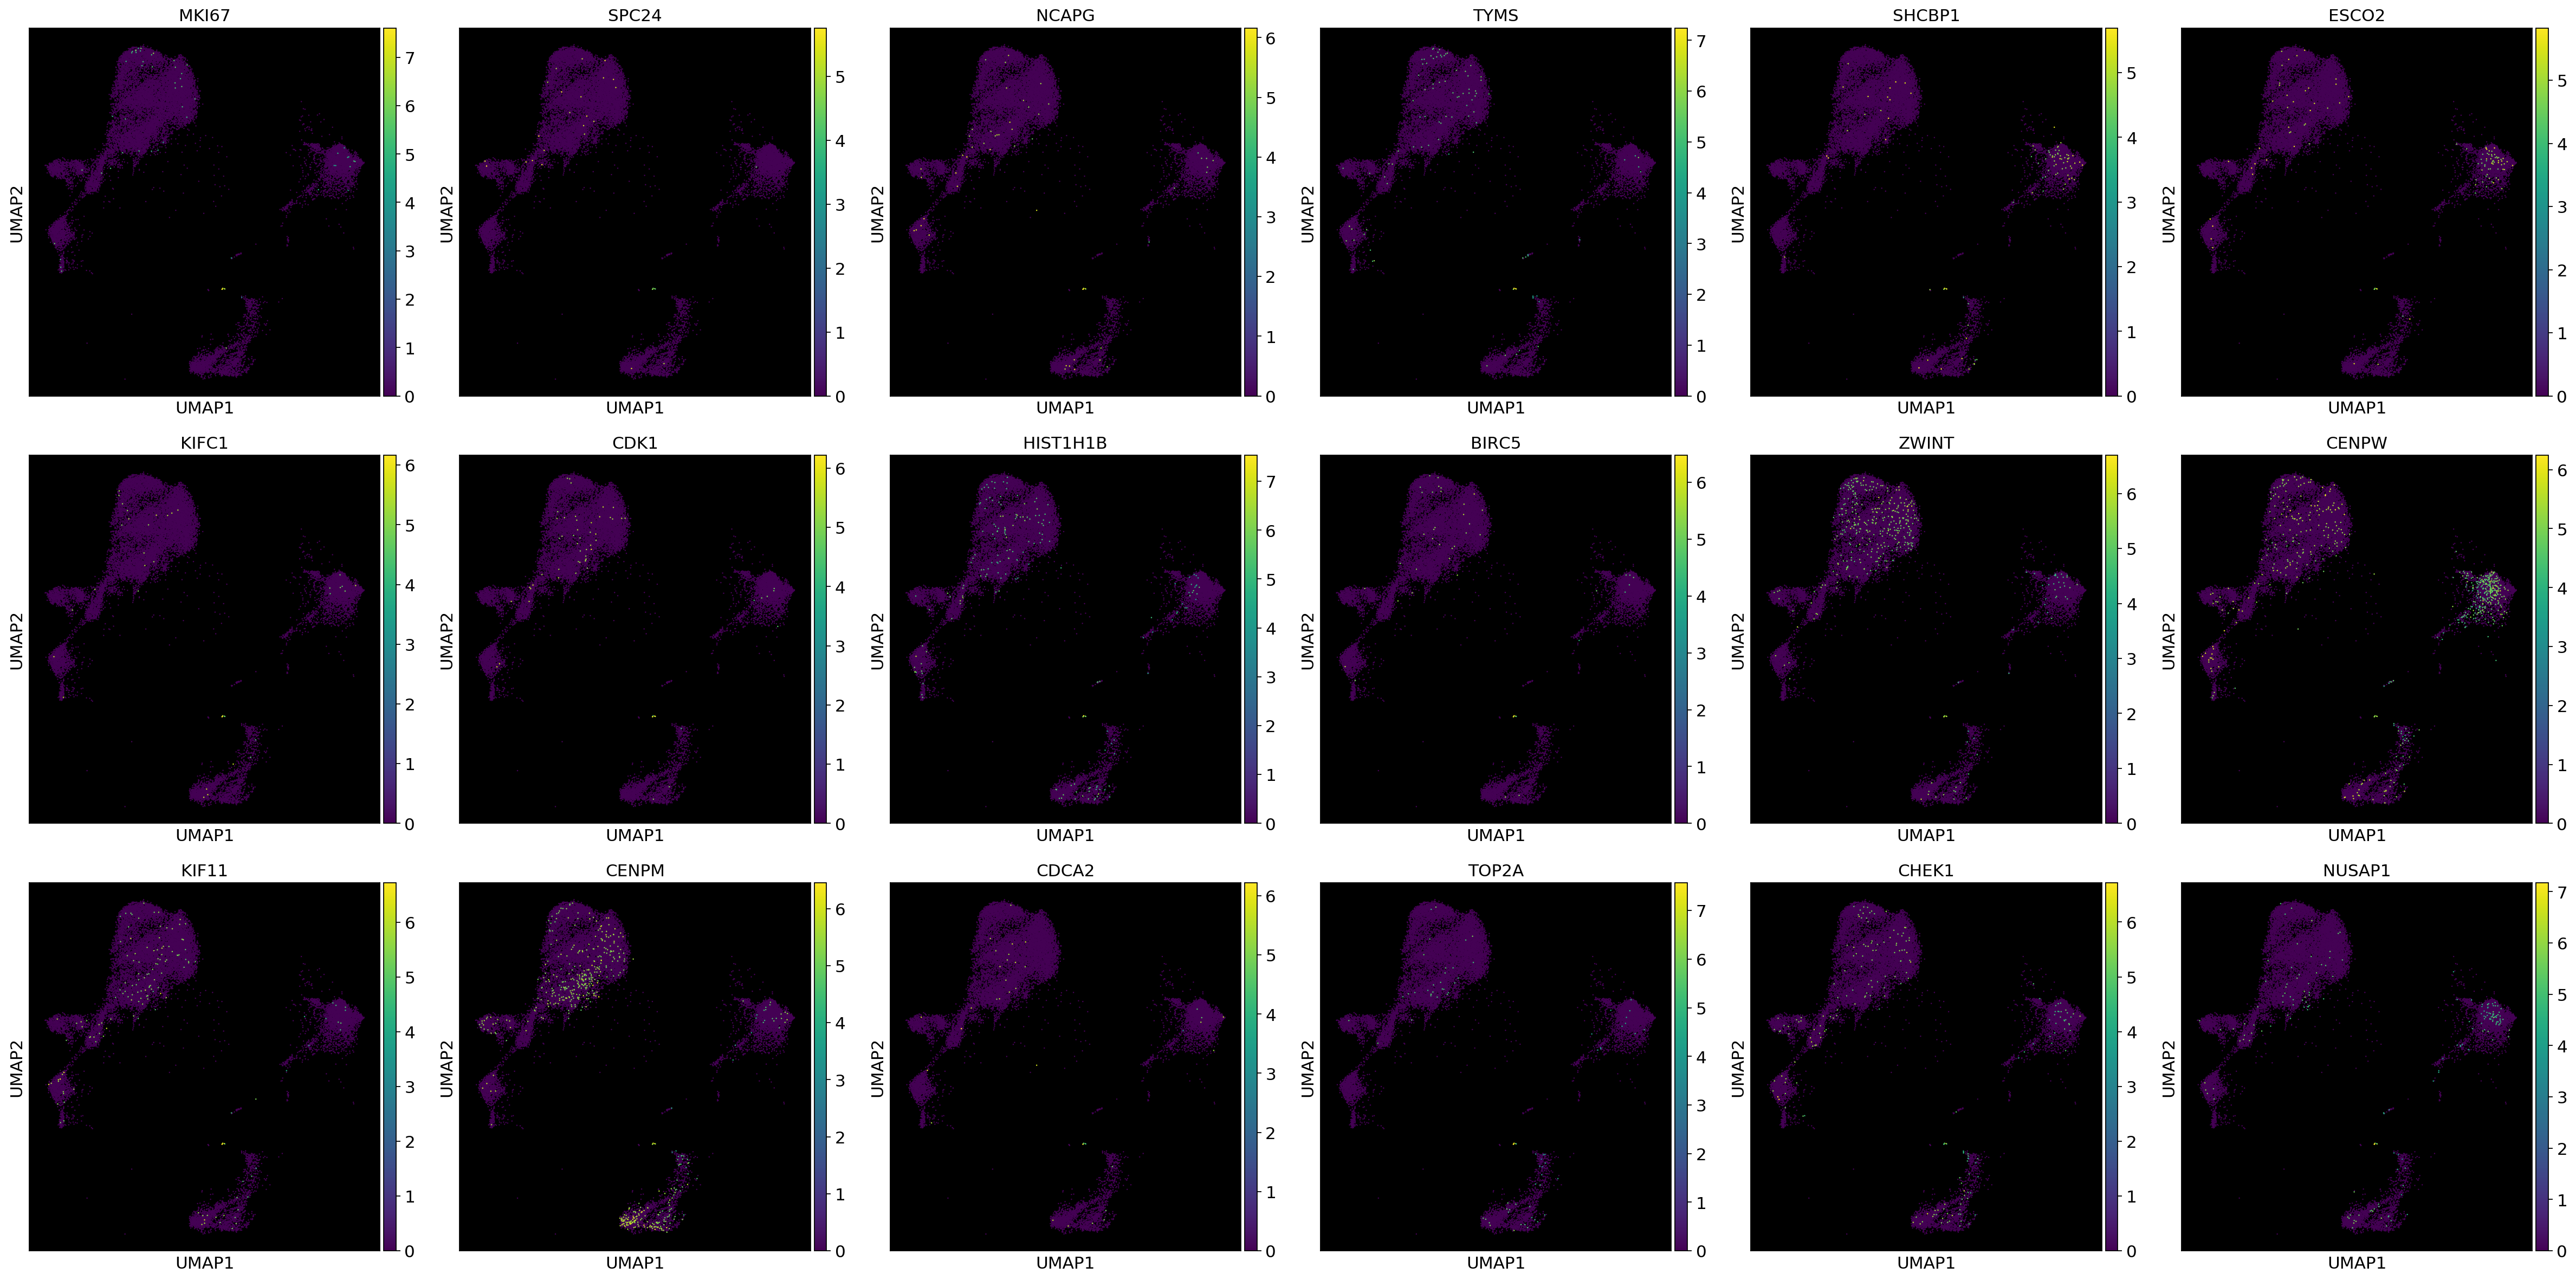

In [197]:
fig, ax = plt.subplots(3, 6, figsize=(30, 15))
for ax, f in tqdm(zip(np.ravel(ax), features)):
    ax.set_facecolor('black')
    sc.pl.umap(concat_ctrl, color=f, ax=ax,show=False, return_fig=False, size=5, use_raw=True)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9.5,10))
for color, ax in zip(['ct2'], [ax]):
    sc.pl.umap(concat_ctrl, color=color, ax=ax, show=False, return_fig=False, size=5)